<a href="https://colab.research.google.com/github/Georopeza/Georopeza-Predictor-Proxima-Palabra-LSTM/blob/main/IAAA_P2_FernandezOropeza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2
Red neuronal recurrente con neuronas LSTM de Keras para predecir la
proxima palabra.

Realizamos las importaciones necesarias y cargamos el archivo

In [ ]:
#Importaciones

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import re
# Cargamos ”Data textual proyecto”.

#Limpiamos el texto
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"—", ".", texto)  # convierte guiones largos de diálogo en puntos
    texto = re.sub(r"[\"“”‘’]", "", texto)  # quita comillas estilizadas
    texto = re.sub(r"[^a-záéíóúñü\s.]", "", texto)  # quita puntuación excepto punto
    texto = re.sub(r"\s+", " ", texto)  # elimina espacios repetidos
    texto = texto.strip()
    return texto
try:
    with open("The Black Cat.txt", 'r', encoding='utf-8') as f:
        texto = f.read().lower().replace('\n', ' ').replace('\r', '') # Convertir a minúsculas y eliminar saltos de línea
        text = limpiar_texto(texto)
        print("Data loaded successfully.")
        print(text)

except FileNotFoundError:
    print("Error: El archivo 'Data textual proyecto' no se encontró.")
    exit()

Data loaded successfully.
the black cat a short story by edgar allan poe wordchecker vocabulary in context for the most wild yet most homely narrative which i am about to pen i neither expect nor solicit belief. mad indeed would i be to expect it in a case where my very senses reject their own evidence. yet mad am i not and very surely do i not dream. but tomorrow i die and today i would unburthen my soul. my immediate purpose is to place before the world plainly succinctly and without comment a series of mere household events. in their consequences these events have terrified have tortured have destroyed me. yet i will not attempt to expound them. to me they have presented little but horror to many they will seem less terrible than barroques. hereafter perhaps some intellect may be found which will reduce my phantasm to the commonplace some intellect more calm more logical and far less excitable than my own which will perceive in the circumstances i detail with awe nothing more than a

Preprocesamos la data

In [ ]:
# Preprocesamos el texto
tokenizer = Tokenizer() #creacion del tokenizador
tokenizer.fit_on_texts([text]) #entrenamiento del tokenizador, cuenta la frecuencia de cada palabra
word_index = tokenizer.word_index #diccionario de palabras tokenizadas
total_words = len(word_index) + 1 #total de palabras unicas +1 ya que reserva indice desde 0 para padding

# Creamos las secuencias de palabras
input_sequences = []
for line in text.split('.'): # Separamos por oraciones para mejorar las secuencias usando el . como delimitador
    token_list = tokenizer.texts_to_sequences([line])[0] #convierte linea en tokens
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Aplicamos padding (rellenar a una longitud uniforme)
max_sequence_len = max([len(x) for x in input_sequences])
padded_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Divide las secuencias rellenadas en entradas (las secuencias de palabras)
# y etiquetas (la siguiente palabra en cada secuencia).
xs, labels = padded_sequences[:,:-1], padded_sequences[:,-1] #xs entrada, labels: prediccion
ys = to_categorical(labels, num_classes=total_words) #vector de 0 con el label en el numero que corresponde en la oracion

Implementamos la red neuronal recurrente con neuronas LSTM de keras

In [ ]:
#Definimos y configuramos el modelo RNN usando Keras
model = Sequential()

#Se definen los parámetros
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1)) #para relacionar mejor las palabras, crea vector de 100
#Numero de neuronas 125
model.add(LSTM(125)) #arbitrario, cuantas mas neuronas mas capacidad de memoria y de deteccion de patrones

model.add(Dropout(0.2)) #desactiva el 20% de las neuronas de la capa anterior
#evita que la red memorice demasiado los datos de entrenamiento

#Capa dense con cantidad de neuronas segun palabras totales, con softmax se indica la probabilidad de que esa palabra es la que se pueda predecir
model.add(Dense(total_words, activation='softmax'))

#Definimos funcion de costo, algoritmo de optimizacion y la metrica a mostrar (en este caso, es la precision)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo

In [ ]:
#Iniciamos el entrenamiento del modelo pasando las secuencias de palabras y la siguiente palabra a predecir con un numero N de épocas
history=model.fit(xs, ys, epochs=75, verbose=1) #75 adecuando para data de tamaño medio

Epoch 1/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step - accuracy: 0.0423 - loss: 6.6452
Epoch 2/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.0670 - loss: 5.8301
Epoch 3/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.0774 - loss: 5.7080
Epoch 4/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.0912 - loss: 5.5743
Epoch 5/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.0987 - loss: 5.4513
Epoch 6/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.1010 - loss: 5.4234
Epoch 7/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.1044 - loss: 5.2910
Epoch 8/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.1165 - loss: 5.1376
Epoch 9/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.1178 - loss: 5.0474
Epoch 10/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.1396 - loss: 4.9082
Epoch 11/75
118/118 ━━━━━━━━━━━━━━━━━━━━ 39s 177ms/step - accuracy: 0.1414 - loss: 4.8225
Epoch 12/75
118/118

Graficamos la precision y error por epocas

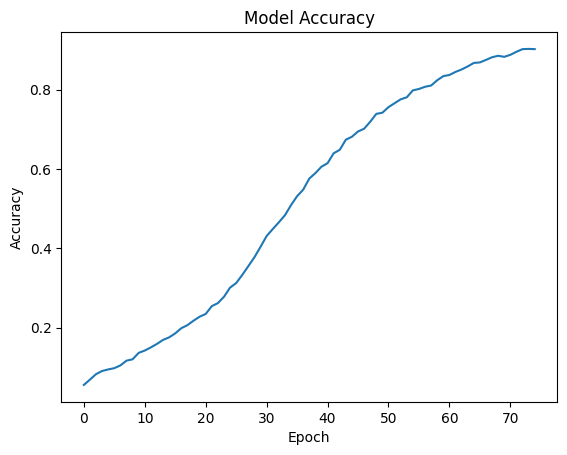

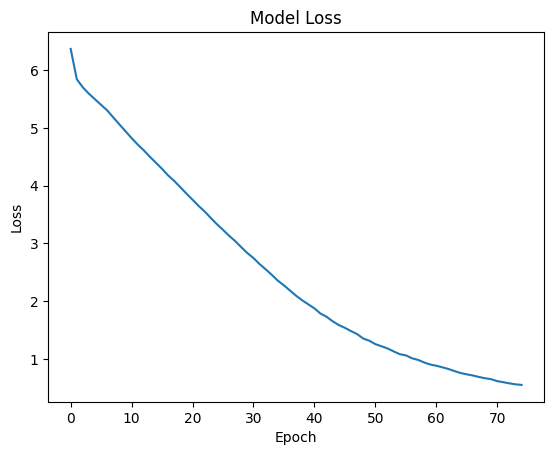

In [ ]:
import matplotlib.pyplot as plt

# Precision del entrenamiento
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Funcion de costo
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Lo probamos

In [ ]:
# Funcion para predecir la siguiente palabra
def predict_n_words(seed_text, model, tokenizer, max_sequence_len, n_words):
    output_text = seed_text
    for _ in range(n_words):
        #Tokenizamos el texto de entrada proporcionado
        token_list = tokenizer.texts_to_sequences([output_text])[0]
        # Aplicamos padding para garantizar que tenga una longitud consistente
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Las palabras tokenizadas se pasan, para encontrar el indice de la palabra con la probabilidad mas alta (softmax)
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
          #Si el indice es igual a la prediccion, es agregada a la salida
            if index == predicted:
                output_word = word
                break
        output_text += " " + output_word
    return output_text

Probamos con el texto que introduzcamos y le damos la cantidad de palabras siguientes que queremos que prediga

In [ ]:
#Texto a introducir para predecir la siguiente palabra
seed_text = "i am above the weakness"
#Numero de palabras a predecir luego del texto
n_words_to_predict = 3
#Llamamos a la funcion para predecir texto
predicted_text = predict_n_words(seed_text, model, tokenizer, max_sequence_len, n_words_to_predict)
print(f"Texto original y predicción de las siguientes {n_words_to_predict} palabras: {predicted_text}")

Texto original y predicción de las siguientes 3 palabras: i am above the weakness of seeking to
